<a href="https://colab.research.google.com/github/lisining5/MERs/blob/master/transfer2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

import pathlib

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.1.0
Hub version: 0.7.0
GPU is available


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
module_selection = ("inception_resnet_v2", 299) #@param ["(\"mobilenet_v2_100_224\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32 #@param {type:"integer"}

Using https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/4 with input size (299, 299)


In [10]:
data_root_orig = "/content/drive/My Drive/myMerPy2/Database_New/CASME2_n299"
data_root = pathlib.Path(data_root_orig)
print(data_root)

/content/drive/My Drive/myMerPy2/Database_New/CASME2_n299


In [11]:
for item in data_root.iterdir():
  print(item)

/content/drive/My Drive/myMerPy2/Database_New/CASME2_n299/surprise
/content/drive/My Drive/myMerPy2/Database_New/CASME2_n299/repression
/content/drive/My Drive/myMerPy2/Database_New/CASME2_n299/others
/content/drive/My Drive/myMerPy2/Database_New/CASME2_n299/disgust
/content/drive/My Drive/myMerPy2/Database_New/CASME2_n299/happiness


In [12]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

254

In [13]:
data_dir = "/content/drive/My Drive/myMerPy2/Database_New/CASME2_n299"
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 49 images belonging to 5 classes.
Found 205 images belonging to 5 classes.


Defining the model
All it takes is to put a linear classifier on top of the feature_extractor_layer with the Hub module.

For speed, we start out with a non-trainable feature_extractor_layer, but you can also enable fine-tuning for greater accuracy.

In [0]:
do_fine_tuning = True #@param {type:"boolean"}

In [24]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/4
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   multiple                  54336736  
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  7685      
Total params: 54,344,421
Trainable params: 54,283,877
Non-trainable params: 60,544
_________________________________________________________________


Training the model

In [0]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.0005, momentum=0.8), 
  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
  metrics=['accuracy'])

In [26]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit_generator(
    train_generator,
    epochs=70, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 6 steps, validate for 1 steps
Epoch 1/70
6/6 [==============================] - 29s 5s/step - loss: 2.0995 - accuracy: 0.2775 - val_loss: 1.8527 - val_accuracy: 0.4375
Epoch 2/70
6/6 [==============================] - 4s 676ms/step - loss: 2.0721 - accuracy: 0.2708 - val_loss: 1.8360 - val_accuracy: 0.6875
Epoch 3/70
6/6 [==============================] - 4s 625ms/step - loss: 2.0104 - accuracy: 0.3757 - val_loss: 1.8285 - val_accuracy: 0.4688
Epoch 4/70
6/6 [==============================] - 4s 631ms/step - loss: 1.9694 - accuracy: 0.3873 - val_loss: 1.8355 - val_accuracy: 0.4688
Epoch 5/70
6/6 [==============================] - 4s 623ms/step - loss: 1.9224 - accuracy: 0.4451 - val_loss: 1.8388 - val_accuracy: 0.4688
Epoch 6/70
6/6 [==============================] - 4s 624ms/step - loss: 1.8919 - accuracy: 0.4740 - val_loss: 1.8343 - val_accuracy: 0.4375
Epoch 7/70
6/6 [==============================] - 4s 614ms/step - loss: 1.8438 - accuracy: 0.4740 - val_loss: 1.8381 - val

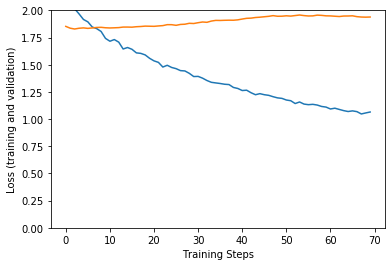

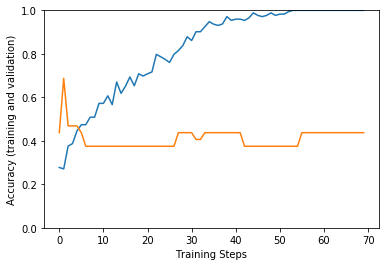

In [27]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [28]:
saved_model_path = "/content/drive/My Drive/myMerPy2/model1"
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: /content/drive/My Drive/myMerPy2/model1/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/myMerPy2/model1/assets


Optional: Deployment to TensorFlow Lite
TensorFlow Lite lets you deploy TensorFlow models to mobile and IoT devices. The code below shows how to convert the trained model to TF Lite and apply post-training tools from the TensorFlow Model Optimization Toolkit. Finally, it runs it in the TF Lite Interpreter to examine the resulting quality

Converting without optimization provides the same results as before (up to roundoff error).
Converting with optimization without any data quantizes the model weights to 8 bits, but inference still uses floating-point computation for the neural network activations. This reduces model size almost by a factor of 4 and improves CPU latency on mobile devices.
On top, computation of the neural network activations can be quantized to 8-bit integers as well if a small reference dataset is provided to calibrate the quantization range. On a mobile device, this accelerates inference further and makes it possible to run on accelerators like EdgeTPU.

In [30]:
#@title Optimization settings
optimize_lite_model = False  #@param {type:"boolean"}
#@markdown Setting a value greater than zero enables quantization of neural network activations. A few dozen is already a useful amount.
num_calibration_examples = 60  #@param {type:"slider", min:0, max:1000, step:1}
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_generator for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

# with open("/tmp/lite_flowers_model", "wb") as f:
with open("/content/drive/My Drive/myMerPy2/model1/saved_model", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

Wrote TFLite model of 217390496 bytes.


In [0]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TF Lite interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [32]:
#@markdown For rapid experimentation, start with a moderate number of examples.
num_eval_examples = 50  #@param {type:"slider", min:0, max:700}
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_generator
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TF Lite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TF Lite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))

TF Lite model agrees with original model on 50 of 50 examples (100%).
TF Lite model is accurate on 43 of 50 examples (86%).
